In [1]:
!pip install tensorflow --quiet
!pip install tensorflow-hub --quiet
!pip install tensorflow-text --quiet
!pip install transformers --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

D0717 09:08:15.900904856    4957 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0717 09:08:15.900934205    4957 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0717 09:08:15.900937432    4957 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0717 09:08:15.900940374    4957 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0717 09:08:15.900942666    4957 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0717 09:08:15.900945081    4957 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0717 09:08:15.900947719    4957 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0717 09:08:15.

In [3]:
# CHANGED FOR TPU 1VM:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
except tf.errors.NotFoundError:
    print("not on TPU")
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

on TPU
REPLICAS:  8


## Import Dataset

In [4]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [5]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Exploratory Data Analysis (EDA)

First, let's check if there are any mislabeled tweets inside the dataset. As we cannot manually inspect all tweets to see if the tweets have been correctly classifier, we are going to look for duplicate tweets and check that duplicates have been assigned to the same labels. 

In [6]:
duplicates = train[train.duplicated('text')]
duplicates.text.nunique()

69

There are 69 duplicate tweets inside the training dataset. We are going to iterate through these duplicate tweets to see if these duplicate tweets have unmatching labels. Unmatching labels would indicate that the tweet(s) has been mislabeled. We are going to store the index of these "problematic duplicates" inside a list and use it to iterature through these tweets so that we can re-assigned the correct labels after inspecting them.

In [7]:
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55, 58]


In [8]:
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,1


Above is the 58th duplicate. We see that these tweets have unmatching labels despite their texts being identical. This tweet is not about an actual disaster, so we are going to correctly assign both tweets as not being about an actual disaster. This is going to look like this: 

In [9]:
train.target = np.where(train.text == duplicates.text.unique()[58], 0, train.target)
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0


Let's repeat this task for all problematic duplicates after having identified the correct labels for each and every one of these problematic duplicates. We are going to store the correct labels inside a list and iterate through the problematic duplicates, assigning the correct labels one after the other.

In [10]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

## Preprocessing the Text

Before we use the text as input, we are going to perform some basic pre-processing. To identify the appropriate steps, let's look at some of the tweets.

In [11]:
random.seed(1048596)
sample_train = train.sample(frac = 1).head(5)
sample_train

,id,keyword,location,text,target
621,894,bioterrorism,New York City,@DrRichardBesser Yes. I would think not. But since college 88-92 it's been difficult not to think of bioterrorism esp. bc 'dispersed.',1
1997,2871,damage,http://twitch.tv/jcmonkey,@Drothvader @CM_Nevalistis you can keep this please!!!!! Arachys\n [2 Pieces] - Now deals 4000% weapon damage (up from 2500%),1
2233,3192,deluge,NaN,I love the song 'healing is here-deluge' &amp;wanted to sing it at my church but it's not in spanish so I translated it. http://t.co/dmrsYeiqZ3,0
2299,3299,demolish,NYHC,If you think going to demolish Drake's house over some ghostwriting shit you should know that Rihanna lives next door.,1
5397,7699,panicking,?^åá??åá?^?? ??,OKAY I CAN'T FIND IT SO I'M KINDA PANICKING,0


In the randomly selected tweets above, we see that the tweets contain links (http://...), hashtags (#..), and mentions (@..). We are going to remove links entirely and keep hashtags and mentions in case they signal something.

In [12]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\W+', ' ', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\d+', '', x))
    return(dataframe)

In [13]:
sample_train = clean_text(sample_train)

In [14]:
sample_train

,id,keyword,location,text,target
621,894,bioterrorism,New York City,drrichardbesser yes i would think not but since college it s been difficult not to think of bioterrorism esp bc dispersed,1
1997,2871,damage,http://twitch.tv/jcmonkey,drothvader cm_nevalistis you can keep this please arachys pieces now deals weapon damage up from,1
2233,3192,deluge,NaN,i love the song healing is here deluge amp wanted to sing it at my church but it s not in spanish so i translated it,0
2299,3299,demolish,NYHC,if you think going to demolish drake s house over some ghostwriting shit you should know that rihanna lives next door,1
5397,7699,panicking,?^åá??åá?^?? ??,okay i can t find it so i m kinda panicking,0


In [22]:
clean_train = clean_text(train)

In [23]:
train_df, val_df = np.split(clean_train.sample(frac = 1), [int(0.8 * len(clean_train))])

## Define and Train Model - First Model

In [15]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [16]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [25]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(100, activation = 'relu')(encoder_output['pooled_output'])
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(25, activation = 'relu')(l)
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [27]:
history = model.fit(train_df.text,
                    train_df.target,
                    validation_data = (val_df.text, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.6153
Epoch 1: val_loss improved from inf to 0.59246, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 406s 2s/step - loss: 0.6523 - accuracy: 0.6153 - val_loss: 0.5925 - val_accuracy: 0.7150
Epoch 2/30
191/191 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.7010
Epoch 2: val_loss improved from 0.59246 to 0.53534, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 400s 2s/step - loss: 0.5959 - accuracy: 0.7010 - val_loss: 0.5353 - val_accuracy: 0.7387
Epoch 3/30
191/191 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7182
Epoch 3: val_loss improved from 0.53534 to 0.51755, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 393s 2s/step - loss: 0.5751 - accuracy: 0.7182 - val_loss: 0.5175 - val_accuracy: 0.7472
Epoch 4/30
191/191 [

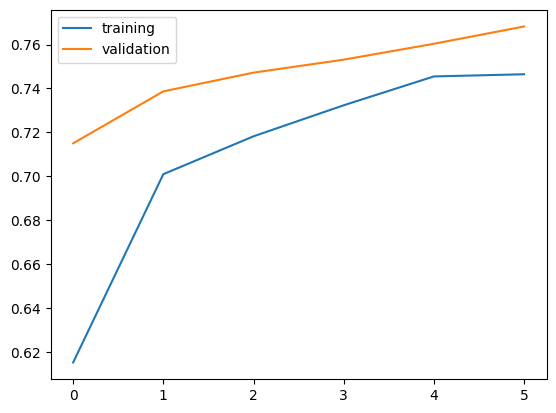

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

In [31]:
model.save('disaster-tweet-bert.model.h5')

In [ ]:
## Define and Train Model - Second Model

In [34]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [35]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [36]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(16, activation = 'relu')(encoder_output['pooled_output'])
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [38]:
history = model.fit(train_df.text,
                    train_df.target,
                    validation_data = (val_df.text, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7115
Epoch 1: val_loss improved from 0.51026 to 0.48169, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 46s 227ms/step - loss: 0.5707 - accuracy: 0.7115 - val_loss: 0.4817 - val_accuracy: 0.7774
Epoch 2/30
191/191 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7665
Epoch 2: val_loss improved from 0.48169 to 0.47899, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 42s 222ms/step - loss: 0.5059 - accuracy: 0.7665 - val_loss: 0.4790 - val_accuracy: 0.7761
Epoch 3/30
191/191 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7803
Epoch 3: val_loss improved from 0.47899 to 0.45784, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 42s 219ms/step - loss: 0.4843 - accuracy: 0.7803 - val_loss: 0.4578 - val_accuracy: 0.7866
Epoch 4/30

In [ ]:
model.save('disaster-tweet-bert-2.model.h5')